# Modeling Molecular Prientation From AR NEXAFS

This notebook is a simple example of how to model the molecular orientation of a molecule from the angle-resolved near-edge X-ray absorption fine structure (AR NEXAFS) spectrum. The AR NEXAFS spectrum is a measure of the absorption of X-rays by a molecule as a function of the incident angle of the X-rays. The absorption is sensitive to the orientation of the molecule with respect to the X-ray beam, and the AR NEXAFS spectrum can be used to determine the orientation of the molecule.


In [151]:
import polars as pl
import matplotlib.pyplot as plt
from matplotlib import rc
from pathlib import Path
import seaborn as sns

sns.set_style("ticks")

font = {  #'family' : 'sans-serif',
    "sans-serif": "DejaVu Sans",
    "weight": "regular",
    "size": 14,
}
rc("font", **font)
# plt.rcParams.update(
#     {
#         "axes.linewidth": 1.5,
#         "xtick.major.size": 6,
#         "xtick.major.width": 1.5,
#         "ytick.major.size": 6,
#         "ytick.major.width": 1.5,
#         "xtick.direction": "in",
#         "ytick.direction": "in",
#         "legend.frameon": True,
#         "legend.edgecolor": "black",
#         "legend.fancybox": False,
#     }
# )

params_path = Path().home() / "projects" / "xrr_notebooks" / "dft_sorted"

In [165]:
# def load_and_prepare_data(file_path) -> pl.DataFrame:
#     """
#     Load and prepare the data from a CSV file.

#     Parameters
#     ----------
#     file_path : str
#         The path to the CSV file.

#     Returns
#     -------
#     pl.DataFrame
#         The prepared DataFrame.
#     """
#     print(file_path)
#     df = pl.read_csv(file_path, has_header=False, skip_rows=1)
#     df.columns = [
#         "energy",
#         "os",
#         "wid",
#         "mu_x",
#         "mu_y",
#         "mu_z",
#         "theta",
#         "sym",
#         "xx",
#         "yy",
#         "zz",
#         "xy",
#         "xz",
#         "yz",
#         "atom",
#         "mo",
#         "cluster",
#         "_",
#     ]
#     df = df.with_columns(
#         [
#             pl.col("energy").cast(pl.Float64),
#             pl.col("os").cast(pl.Float64),
#             pl.col("wid").cast(pl.Float64),
#             pl.col("mu_x").cast(pl.Float64),
#             pl.col("mu_y").cast(pl.Float64),
#             pl.col("mu_z").cast(pl.Float64),
#             pl.col("theta").cast(pl.Float64),
#             pl.col("sym").cast(pl.Float64),
#             pl.col("xx").cast(pl.Float64),
#             pl.col("yy").cast(pl.Float64),
#             pl.col("zz").cast(pl.Float64),
#             pl.col("xy").cast(pl.Float64),
#             pl.col("xz").cast(pl.Float64),
#             pl.col("yz").cast(pl.Float64),
#             pl.col("mo").cast(pl.Int64),
#             pl.col("cluster").cast(pl.Int64),
#         ]
#     )
#     return df.drop(["_"])


df = load_and_prepare_data(params_path / "znpc_params.csv")

/home/hduva/projects/xrr_notebooks/dft_sorted/znpc_params.csv


In [168]:
_ = [print(col, end=",") for col in df.columns]

energy,os,wid,mu_x,mu_y,mu_z,theta,sym,xx,yy,zz,xy,xz,yz,atom,mo,cluster,

shape: (599, 2)
┌───────────┬──────────┐
│ E_55      ┆ ZnPc_55  │
│ ---       ┆ ---      │
│ f64       ┆ f64      │
╞═══════════╪══════════╡
│ 270.2002  ┆ 0.027387 │
│ 270.30035 ┆ 0.029883 │
│ 270.40021 ┆ 0.02957  │
│ 270.50003 ┆ 0.024998 │
│ 270.59988 ┆ 0.03069  │
│ …         ┆ …        │
│ 329.59964 ┆ 0.963274 │
│ 329.69928 ┆ 0.960109 │
│ 329.80051 ┆ 0.958406 │
│ 329.89813 ┆ 0.958699 │
│ 330.00116 ┆ 0.957323 │
└───────────┴──────────┘


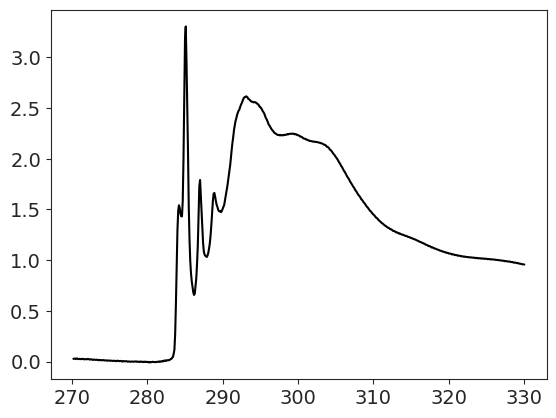

In [169]:
import pandas as pd

exp = pd.read_csv((params_path / "nexafs"))
exp = pl.DataFrame(exp)
exp = exp.drop(["eV_", "TotalSpec_NEXAFS"])
# drop nulls
exp = exp.filter(exp["E_55"].is_not_null())
print(exp)

plt.plot(exp["E_55"], exp["ZnPc_55"], label="Experiment", color="black")

In [180]:
# calculate the mass absorbance from the tdm components and energy widths
import numpy as np
import numba as nb


@nb.jit(nopython=True)
def e_field(theta: float, phi: float):
    return np.array(
        [[np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)]]
    ).T


@nb.jit(nopython=True)
def gauss(x: np.ndarray, xc: float, wx: float):
    return np.exp(-((x - xc) ** 2) / (2 * wx**2)) / np.sqrt(2 * np.pi) / wx


@nb.jit(nopython=True)
def rot(x: float, y: float, z: float):
    return np.array(
        [
            [
                np.cos(y) * np.cos(z),
                np.cos(z) * np.sin(x) * np.sin(y) - np.cos(x) * np.sin(z),
                np.cos(x) * np.cos(z) * np.sin(y) + np.sin(x) * np.sin(z),
            ],
            [
                np.cos(y) * np.sin(z),
                np.cos(x) * np.cos(z) + np.sin(x) * np.sin(y) * np.sin(z),
                -np.cos(z) * np.sin(x) + np.cos(x) * np.sin(y) * np.sin(z),
            ],
            [-np.sin(y), np.cos(y) * np.sin(x), np.cos(x) * np.cos(y)],
        ]
    )


def mass_absorbance(mu: np.ndarray, theta: float, phi: float, alpha: float = 0):
    # Average the mass absorbance over all directions
    mu_avg = (
        mu
        + rot(0, 0, np.pi / 2).T @ mu @ rot(0, 0, np.pi / 2)
        + rot(0, 0, np.pi).T @ mu @ rot(0, 0, np.pi)
        + rot(0, 0, 2 * np.pi / 2).T @ mu @ rot(0, 0, 2 * np.pi / 2)
    ) / 4

    # Tilt the molecule by alpha
    mu = rot(0, 0, alpha).T @ mu_avg @ rot(0, 0, alpha)
    return (e_field(theta, phi).T @ mu @ e_field(theta, phi))[0, 0]


def tdm_matrix(df: pl.DataFrame):
    mu = np.array(
        [
            [df["xx"], df["xy"], df["xz"]],
            [df["xy"], df["yy"], df["yz"]],
            [df["xz"], df["yz"], df["zz"]],
        ]
    )
    return mu

In [181]:
tdm_matrix(df).shape

(3, 3, 1128)

In [209]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from typing import Tuple


def get_ma(df: pl.DataFrame, theta: float = 54.7, phi: float = 0, alpha: float = 0):
    theta = np.deg2rad(theta)
    phi = np.deg2rad(phi)
    alpha = np.deg2rad(alpha)
    mu = tdm_matrix(df)
    # iterate over the chunks of the mu ndarray
    ma = []
    for i in range(mu.shape[2]):
        ma.append(mass_absorbance(mu[:, :, i], theta, phi, alpha))
    # print(ma)
    new_df = pl.DataFrame(
        {
            "energy": df["energy"],
            "ma": pl.Series(ma),
            "width": df["wid"],
            "atom": df["atom"],
            # "cluster": df["cluster"],
        }
    )
    return new_df.sort(["atom"])


def align_peaks(exp_mu: list, exp_en: list, mu: list, en: list) -> Tuple[float, float]:
    """
    Align the peaks of the experimental and calculated data.

    Parameters
    ----------
    exp_data : pl.DataFrame
        The experimental data.
    calc_data : pl.DataFrame
        The calculated data.

    Returns
    -------
    pl.DataFrame
        The aligned calculated data.
    """
    calc_peak, _ = find_peaks(mu, prominence=0.0001)
    exp_peak, _ = find_peaks(exp_mu, prominence=0.05)

    energy_diff = exp_en[exp_peak[0]] - en[calc_peak[0]]
    exp_en -= energy_diff

    # multiplicative sclae to reduce the experimental intensity
    scale = mu[calc_peak[0]] / exp_mu[exp_peak[0]]
    exp_mu = np.array(exp_mu) * scale

    return exp_en, exp_mu

In [210]:
colors = [
    "#75eab6",
    "#169294",
    "#77d1fd",
    "#3986da",
    "#ee80fe",
    "#dabed9",
    "#fe16f4",
    "#abe65b",
    "#6a9012",
    "#b5ceaa",
    "#0ca82e",
    "#53f259",
    "#c0710c",
    "#f6bb86",
    "#f7393a",
    "#a57a6a",
    "#fbd127",
    "#ff0087",
    "#f68aad",
]

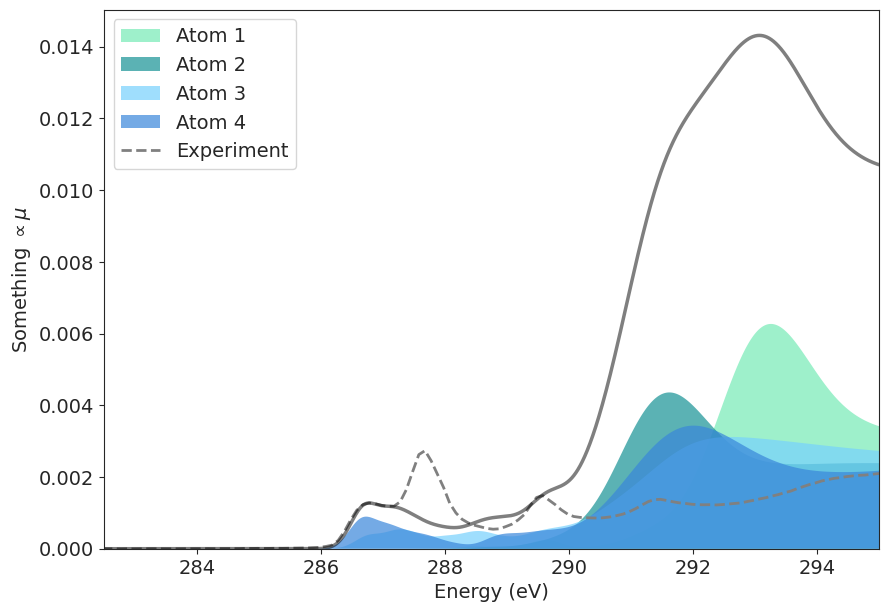

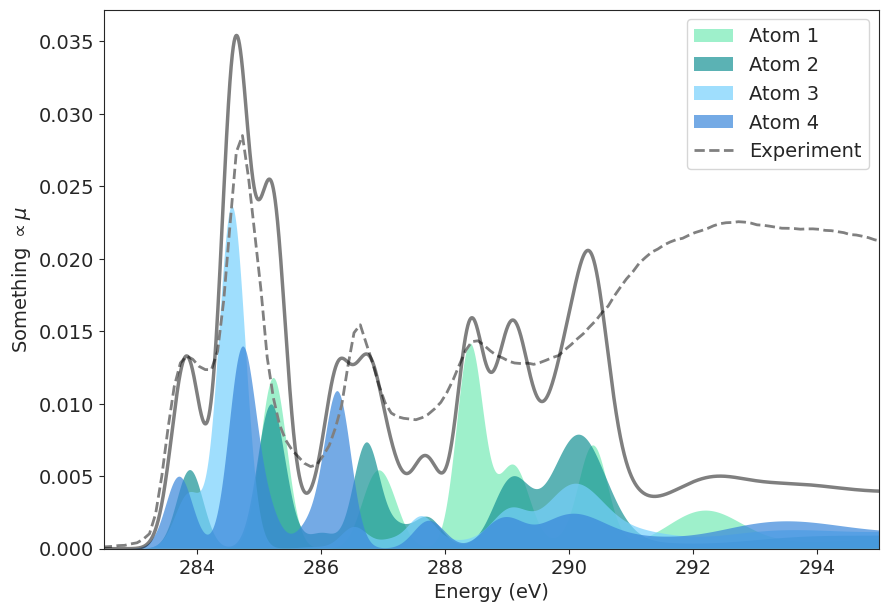

In [214]:
import seaborn as sns
from scipy.special import wofz

sns.set_palette(colors)


def plot_ma(
    ax: plt.Axes,
    ma_df: pl.DataFrame,
    exp_df: pl.DataFrame,
    max_atom: int = 5,
    energy_range: Tuple[float, float] = (280, 300),
    num_points: int = 10000,
    color: str = None,
) -> None:
    atoms = ma_df["atom"].unique()
    e = np.linspace(energy_range[0], energy_range[1], num_points)
    mu = 0

    for atom in atoms:
        if atom == max_atom:
            break
        atom_df = ma_df.filter(pl.col("atom") == atom)
        atom_mu = 0
        for row in atom_df.iter_rows():
            atom_mu += row[1] * gauss(e, row[0], row[2])

        mu += atom_mu
        if color:
            ax.fill_between(
                e,
                atom_mu,
                label=f"Atom {atom}",
                alpha=0.7,
                edgecolor="none",
                color=color,
            )
        else:
            ax.fill_between(
                e, atom_mu, label=f"Atom {atom}", alpha=0.7, edgecolor="none"
            )
    return e, mu, ax


def plot_spectra(
    ma_df: pl.DataFrame,
    exp_df: pl.DataFrame,
    max_atom: int = 5,
    energy_range: Tuple[float, float] = (280, 300),
    num_points: int = 10000,
) -> None:
    """
    Plot the mass absorbance for each atom up to a specified maximum atom.

    Parameters
    ----------
    ma_df : pl.DataFrame
        The DataFrame containing mass absorbance data.
    max_atom : int, optional
        The maximum atom number to plot, by default 5.
    energy_range : Tuple[float, float], optional
        The range of energy values to plot, by default (280, 300).
    num_points : int, optional
        The number of points in the energy range, by default 10000.
    """
    fig, ax = plt.subplots(figsize=(10, 7))
    e, mu, ax = plot_ma(ax, ma_df, exp_df, max_atom, energy_range, num_points)

    exp_e, exp_mu = align_peaks(
        exp_df["ZnPc_55"].to_list(), exp_df["E_55"].to_list(), mu, e
    )

    # Locate the maximum in the experimental data
    ax.plot(
        exp_e,
        exp_mu,
        label="Experiment",
        linestyle="--",
        color="grey",
        linewidth=2,
    )
    ax.legend()
    ax.plot(e, mu, label="Total", linewidth=2.5, color="Black", alpha=0.5)
    ax.set_xlabel("Energy (eV)")
    ax.set_ylabel(r"Something $\propto\mu$")
    ax.set_xlim(282.5, 295)
    ax.set_ylim(bottom=0)
    plt.show()
    return e, mu


# Call the function
perp = get_ma(df, theta=90, alpha=62)
para = get_ma(df, theta=0, alpha=62)
e, mu_perp = plot_spectra(perp, exp)
e, mu_para = plot_spectra(para, exp)

In [235]:
from kkcalc import kk

chemical_formula = "C32H16N8Zn"

para = np.array([e, mu_para])
np.savetxt(params_path / "para.csv", para.T, fmt="%.6f", delimiter="\t")
perp = np.array([e, mu_perp])
np.savetxt(params_path / "perp.csv", perp.T, fmt="%.6f", delimiter="\t")

real = kk.kk_calculate_real(
    str(params_path / "para.csv"),
    chemical_formula,
    load_options=None,
    input_data_type="nexafs",
    merge_points=(270, 310),
    add_background=False,
    fix_distortions=False,
    curve_tolerance=0.05,
    curve_recursion=100,
)

(282.5, 295.0)

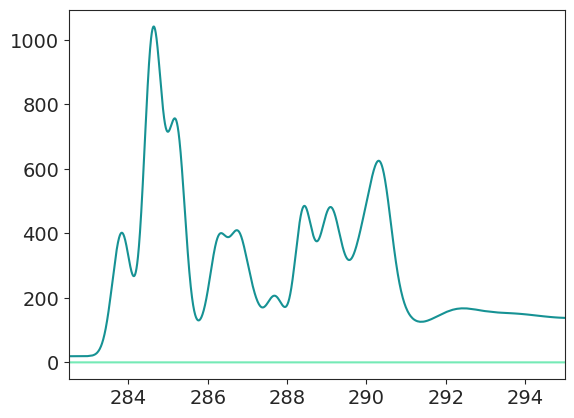

In [242]:
st = kk.data.ParseChemicalFormula(chemical_formula)
formula_mass = kk.data.calculate_FormulaMass(st)


delta = kk.data.convert_data(
    real[:, [0, 1]], "ASF", "refractive_index", Density=1.6, Formula_Mass=formula_mass
)
beta = kk.data.convert_data(
    real[:, [0, 2]],
    "ASF",
    "extinction_coefficient",
    Density=1.6,
    Formula_Mass=formula_mass,
)[:, 1]
energy = delta[:, 0]
delta = delta[:, 1]
plt.plot(energy, delta, label="delta")
plt.plot(energy, beta, label="beta")
plt.xlim(282.5, 295)

shape: (19, 7)
┌─────────┬────────────────┬────────────┬─────────────┬──────────────┬──────────────┬──────────────┐
│ cluster ┆ cluster_energy ┆ cluster_os ┆ cluster_wid ┆ cluster_mu_x ┆ cluster_mu_y ┆ cluster_mu_z │
│ ---     ┆ ---            ┆ ---        ┆ ---         ┆ ---          ┆ ---          ┆ ---          │
│ i64     ┆ f64            ┆ f64        ┆ f64         ┆ f64          ┆ f64          ┆ f64          │
╞═════════╪════════════════╪════════════╪═════════════╪══════════════╪══════════════╪══════════════╡
│ 0       ┆ 283.839672     ┆ 0.001529   ┆ 0.212314    ┆ 0.001289     ┆ 0.001289     ┆ 0.999998     │
│ 1       ┆ 284.651125     ┆ 0.0098735  ┆ 0.212314    ┆ 0.001276     ┆ 0.001276     ┆ 0.999998     │
│ 2       ┆ 285.257098     ┆ 0.002641   ┆ 0.212314    ┆ 0.002747     ┆ 0.002747     ┆ 0.999982     │
│ 3       ┆ 285.892088     ┆ 0.000287   ┆ 0.212314    ┆ 0.001358     ┆ 0.001358     ┆ 0.999998     │
│ 4       ┆ 286.27255      ┆ 0.005706   ┆ 0.212314    ┆ 0.001372     ┆ 0.001

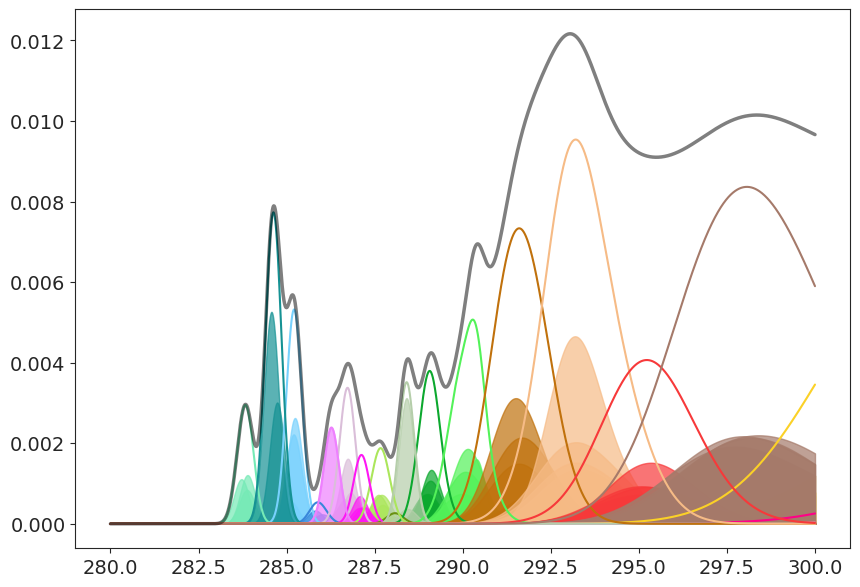

In [192]:
# cluster the spectr

lzf = (
    df.lazy()
    .group_by("cluster")
    .agg(
        (pl.col("energy").mean().alias("cluster_energy")),
        (pl.col("os").mean().alias("cluster_os")),
        (pl.col("wid").mean().alias("cluster_wid")),
        (pl.col("mu_x").mean().alias("cluster_mu_x")),
        (pl.col("mu_y").mean().alias("cluster_mu_y")),
        (pl.col("mu_z").mean().alias("cluster_mu_z")),
    )
)
print(lzf.collect().sort("cluster_energy"))

# plot the mass absorbance for each cluster
fig, ax = plt.subplots(figsize=(10, 7))
mus = 0
for row in lzf.collect().iter_rows(named=True):
    cluster = row["cluster"]
    cluster_df = df.filter(pl.col("cluster") == cluster)
    ma_df = get_ma(cluster_df, theta=np.deg2rad(61.83))
    e, mu, _ = plot_ma(ax, ma_df, exp, color=f"C{cluster}")
    ax.plot(e, mu, label=f"Cluster {row['cluster']}", color=f"C{cluster}")
    mus += mu
ax.plot(e, mus, label="Total", linewidth=2.5, color="Black", alpha=0.5)